## CNN With Supervised Learning

NOTE: The code has been optimized to work on Visual Code Studio.

To run this code, have the unziped folder "data_256" in the same folder as the code ("cnn.ipynb"). And run all the boxes one after the other.
This will :
- preprocess the data,
- split it into training, validation and testing sets and print the number of images in each of those sets,
- Display an image from the dataset,
- display one batch from the training dataset,
- perfrom the training on the model and print, for each epoch, the loss on the training and validation sets and the accuracy on the validation set,
- plot the accuracy on the validation set on the number of epochs,
- plot the losses on the training and validation sets on teh number of epochs,
- perform the testing on the testing set and return the corresponding loss, accuracy, precision, recall, and f1-score as well as plot the confusion matrix,
- start a game where it will show you an image and you will have to compete against the model to find from which class this image is from.
- save the model to a file "CNN256.pt"

If you want to test the model on a sample data_set, please refer to the code "cnn_sample.ipynb".

### Import libraries :

In [215]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import PIL
# import cv2
# import os
import pathlib
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


### Remove folders if needed

In [216]:
def delete_folder(folder_name):
  directory_to_delete="./data_256_" + folder_name
  try:
    shutil.rmtree(directory_to_delete)

  except Exception as e:
    print(e)

In [217]:
delete_folder("___")

[WinError 3] The system cannot find the path specified: './data_256____'


### increase maximum display limit

In [218]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Check the count for the uploaded data

In [219]:
data_dir = pathlib.Path('./data_256')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5000


### Preproccessing
Our first step is to reduce the dimensionality of our dataset images because of the limited resources we have.
 We resize the image and transform it to tensor for it to be used in our cnn algorithm

In [220]:
# from torchvision import transforms

# data_dir = "./data_256/"
# dataset = ImageFolder(data_dir,transform = transforms.Compose([
#     transforms.Resize((256,256)),transforms.ToTensor()
# ])) # saved to disk

In [221]:
# img, label = dataset[0]
# print(img.shape,label) #we have color images and the labels are encoded
# print(len(dataset))

### Split dataset

In [222]:
# #Define the size of the batches
# batch_size=32

# # Define the size of the dataset and the split
# dataset_size = len(dataset)
# train_size = int(0.64 * dataset_size)  # 64% for training
# validation_size=int(0.16 * dataset_size)  # 16% for validation
# test_size = dataset_size - train_size - validation_size  # 20% for testing

# # Split the dataset into training and test sets
# train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# # Create DataLoaders for the training and test sets
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True) # shuffle at every epoch, pinned Memory to optimizes data transfer between CPU and GPU
# validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True) 
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True) # do not shuffle validation and test

# #verify lengths
# print(f"Length of daraset :         {dataset_size}")
# print(f"Length of Train Data :      {len(train_dataset)}")
# print(f"Length of Validation Data : {len(validation_dataset)}")
# print(f"Length of Test Data :       {len(test_dataset)}")

### Preprocession and splitting with data augmentation

In [223]:
import torchvision.transforms as transforms

# Load dataset without any initial transforms
data_dir = "./data_256/"
dataset = ImageFolder(data_dir)


# Define the size of the dataset and the split
dataset_size = len(dataset)
train_size = int(0.64 * dataset_size)  # 64% for training
validation_size=int(0.16 * dataset_size)  # 16% for validation
test_size = dataset_size - train_size - validation_size  # 20% for testing

# Split the dataset into training and test sets
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])


import torchvision.transforms as transforms

# Define data augmentation and preprocessing transformations for the training data
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(256),        # Randomly crop the image to 256x256 and resize
    transforms.RandomHorizontalFlip(),        # Randomly flip the image horizontally
    transforms.RandomRotation(15),            # Randomly rotate the image by 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color adjustments
    transforms.ToTensor(),                    # Convert the image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize the image
])

# Define transformations for the validation and test data
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Set the transformations for the subsets
train_dataset.dataset.transform = train_transforms
validation_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

#Define the size of the batches
batch_size=32

# Create DataLoaders for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True) # shuffle at every epoch, pinned Memory to optimizes data transfer between CPU and GPU
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, pin_memory=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True) # do not shuffle validation and test

#verify lengths
print(f"Length of daraset :         {dataset_size}")
print(f"Length of Train Data :      {len(train_dataset)}")
print(f"Length of Validation Data : {len(validation_dataset)}")
print(f"Length of Test Data :       {len(test_dataset)}")

Length of daraset :         5000
Length of Train Data :      3200
Length of Validation Data : 800
Length of Test Data :       1000


### Display an image from the dataset and display one batch from the train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3611329].


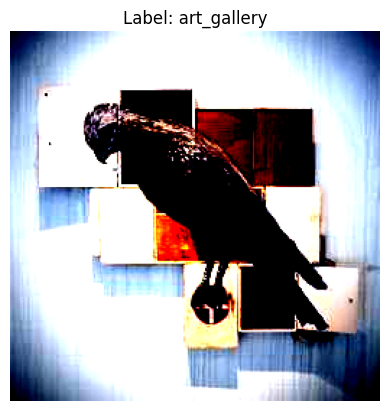

In [224]:
# Function to convert a tensor to a numpy array
def imshow(image_tensor, label):
    image = image_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')  # Hide axes
    plt.show()

# Get an image from the dataset
image, label = dataset[0]

# Get the class name using the dataset class_to_idx mapping
class_name = dataset.classes[label]

# Display the image and print the label
imshow(image, class_name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


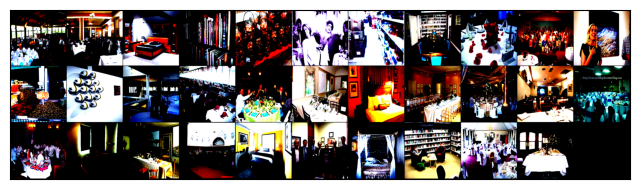

In [225]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, _ in dl:
        _,ax = plt.subplots(figsize = (8,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=11).permute(1,2,0))
        break # to show only one batch
           
show_batch(train_dataloader)

### Architecture of the CNN and definition of the metrics

In [226]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, stride=1, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, stride=1, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.fc1 = nn.Linear(in_features=32 * 64 * 64, out_features=128)
#         self.fc2 = nn.Linear(in_features=128, out_features=len(dataset.classes))
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 32 * 64 * 64)  # Flatten the tensor
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# model=CNN()

In [227]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
        
#         # Layer 1: Convolutional, ReLU, MaxPooling, BatchNormalization
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(32)
#         )
        
#         # Layer 2: Convolutional, ReLU, MaxPooling, BatchNormalization
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(64)
#         )
        
#         # Layer 3: Convolutional, ReLU, MaxPooling, BatchNormalization
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(128)
#         )
        
#         # Layer 4: Convolutional, ReLU, MaxPooling, BatchNormalization
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(256)
#         )
        
#         # Layer 5: Convolutional, ReLU, MaxPooling, BatchNormalization
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(512)
#         )
        
#         # Adaptive pooling to ensure output size is (1, 1)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
#         # Fully connected layers for classification
#         self.fc1 = nn.Linear(512, 256)
#         self.fc2 = nn.Linear(256, 10)  # Adjust 10 based on your number of classes
        
#     def forward(self, x):
#         # Forward pass through the layers
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
        
#         # Adaptive average pooling to (1, 1)
#         out = self.avgpool(out)
        
#         # Flatten for fully connected layers
#         out = torch.flatten(out, 1)
        
#         # Fully connected layers
#         out = self.fc1(out)
#         out = self.fc2(out)
        
#         return out

# # Create an instance of the CNN model
# model = CNN()

In [228]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Layer 1: Convolutional, ReLU, MaxPooling, BatchNormalization, Dropout
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.Dropout(0.25)  # Adding dropout with p=0.25
        )
        
        # Layer 2: Convolutional, ReLU, MaxPooling, BatchNormalization, Dropout
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25)  # Adding dropout with p=0.25
        )
        
        # Layer 3: Convolutional, ReLU, MaxPooling, BatchNormalization, Dropout
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25)  # Adding dropout with p=0.25
        )
        
        # Layer 4: Convolutional, ReLU, MaxPooling, BatchNormalization, Dropout
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25)  # Adding dropout with p=0.25
        )
        
        # Layer 5: Convolutional, ReLU, MaxPooling, BatchNormalization, Dropout
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.Dropout(0.25)  # Adding dropout with p=0.25
        )
        
        # Adaptive pooling to ensure output size is (1, 1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 5)  # because 5 classes

        #Softmax
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Forward pass through the layers
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        # Adaptive average pooling to (1, 1)
        out = self.avgpool(out)
        
        # Flatten for fully connected layers
        out = torch.flatten(out, 1)
        
        # Fully connected layers
        out = self.fc1(out)
        out = self.fc2(out)

        # Softmax
        # out = self.softmax(out)
        
        return out

# Create an instance of the CNN model
model = CNN()

In [229]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
        
#         # Layer 1: Convolutional, ReLU, MaxPooling, BatchNormalization, Dropout
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(32),
#             nn.Dropout(0.25)  # Adding dropout with p=0.25
#         )
        
#         # Layer 2: Convolutional, ReLU, MaxPooling, BatchNormalization, Dropout
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(64),
#             nn.Dropout(0.25)  # Adding dropout with p=0.25
#         )
        
#         # Layer 3: Convolutional, ReLU, MaxPooling, BatchNormalization, Dropout
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.BatchNorm2d(128),
#             nn.Dropout(0.25)  # Adding dropout with p=0.25
#         )
        
#         # Adaptive pooling to ensure output size is (1, 1)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
#         # Fully connected layers for classification
#         self.fc1 = nn.Linear(128, 64)
#         self.fc2 = nn.Linear(64, 10)  # Adjust 10 based on your number of classes
        
#     def forward(self, x):
#         # Forward pass through the layers
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
        
#         # Adaptive average pooling to (1, 1)
#         out = self.avgpool(out)
        
#         # Flatten for fully connected layers
#         out = torch.flatten(out, 1)
        
#         # Fully connected layers
#         out = self.fc1(out)
#         out = self.fc2(out)
        
#         return out

# # Create an instance of the CNN model
# model = CNN()

In [230]:
if torch.cuda.is_available():
    model = model.cuda() #Move the model to GPU if available

### Training

In [231]:
def fit(num_epochs, lr, weight_decay, model, train_dataloader, validation_dataloader, opt_func = torch.optim.SGD):
    
    history=[]

    criterion = nn.CrossEntropyLoss()
    optimizer = opt_func(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        
        model.train()

        running_loss=0.0

        for images,labels in train_dataloader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        
        model.eval()
        
        running_loss_val=0.0
        running_acc_val=0.0
        
        for images, labels in validation_dataloader :
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            #loss
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss_val += loss.item()

            #accuracy
            _, preds = torch.max(outputs, dim=1) # predicted class indices for each example in the batch
            acc= torch.tensor(torch.sum(preds == labels).item() / len(preds)) #Get accuracy : counts the number of correct predictions and divide by number of predictions in the batch 

            running_acc_val += acc.item()



        # loss / accuracy is the average of the losses/accuracies on each batch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss Train: {running_loss/len(train_dataloader):.4f}, Loss Val.: {running_loss_val/len(validation_dataloader):.4f}, Acc. Val.: {running_acc_val/len(validation_dataloader):.4f}')
        history.append([epoch, running_loss/len(train_dataloader), running_loss_val/len(validation_dataloader), running_acc_val/len(validation_dataloader)])
         
    
    return history

In [232]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001
weight_decay = 1e-4
#fitting the model on training data and record the result after each epoch
history= fit(num_epochs, lr, weight_decay, model, train_dataloader, validation_dataloader, opt_func)

Epoch [1/20], Loss Train: 1.3700, Loss Val.: 1.1812, Acc. Val.: 0.4938
Epoch [2/20], Loss Train: 1.1715, Loss Val.: 1.0279, Acc. Val.: 0.5800
Epoch [3/20], Loss Train: 1.0604, Loss Val.: 0.9569, Acc. Val.: 0.6300
Epoch [4/20], Loss Train: 0.9542, Loss Val.: 0.9503, Acc. Val.: 0.6188
Epoch [5/20], Loss Train: 0.8637, Loss Val.: 0.7741, Acc. Val.: 0.7262
Epoch [6/20], Loss Train: 0.7941, Loss Val.: 0.8521, Acc. Val.: 0.6725
Epoch [7/20], Loss Train: 0.7603, Loss Val.: 0.8513, Acc. Val.: 0.6500
Epoch [8/20], Loss Train: 0.7083, Loss Val.: 0.7411, Acc. Val.: 0.7188
Epoch [9/20], Loss Train: 0.6721, Loss Val.: 0.7254, Acc. Val.: 0.7200
Epoch [10/20], Loss Train: 0.6062, Loss Val.: 0.8077, Acc. Val.: 0.6925
Epoch [11/20], Loss Train: 0.5906, Loss Val.: 0.7403, Acc. Val.: 0.7275
Epoch [12/20], Loss Train: 0.5400, Loss Val.: 0.7537, Acc. Val.: 0.7312
Epoch [13/20], Loss Train: 0.4615, Loss Val.: 0.6745, Acc. Val.: 0.7700
Epoch [14/20], Loss Train: 0.4570, Loss Val.: 1.0187, Acc. Val.: 0.7050
E

### Plot

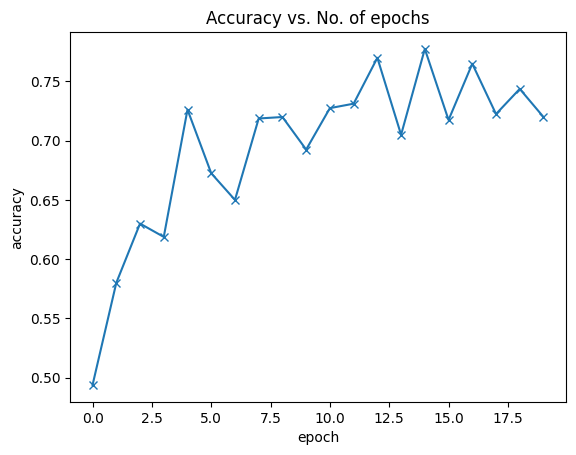

In [233]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x[3] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    

plot_accuracies(history)

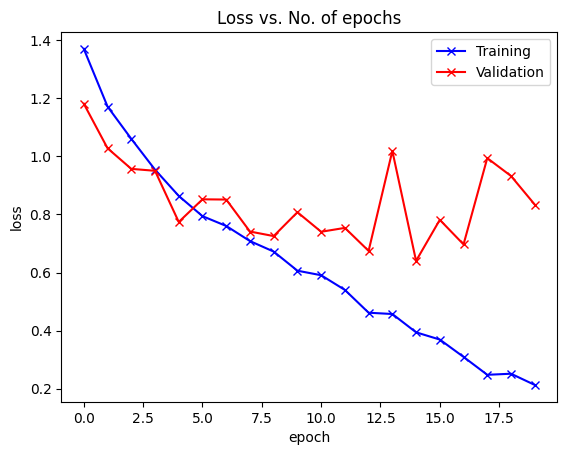

In [234]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x[1] for x in history]
    val_losses = [x[2] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

### Testing

Loss:      0.7740
Accuracy:  0.7480
Precision: 0.7746
Recall:    0.7480
F1-score:  0.7456


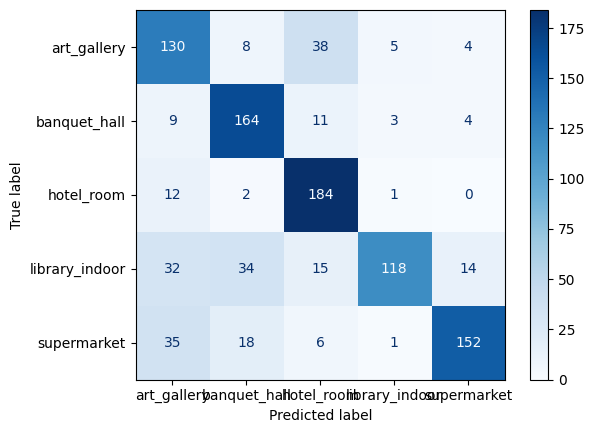

In [235]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

criterion = nn.CrossEntropyLoss() #respecify it because it was specified in a def

# model.eval()

running_loss_test=0.0

# store all the predictions of the testing dataset to do a confusion matrix
all_preds = []
all_labels = []

with torch.no_grad(): #don't calculate gradiants because don't need to update the model weights
    for images, labels in test_dataloader :
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        #loss
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss_test += loss.item()

        #prediction -> prepare for the confusion matrix and metrics
        _, preds = torch.max(outputs, dim=1) # predicted class indices for each example in the batch
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision, recall, and F-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Loss:      {running_loss_test/len(test_dataloader):.4f}')
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
_=disp.plot(cmap=plt.cm.Blues)
plt.show()

### Game

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


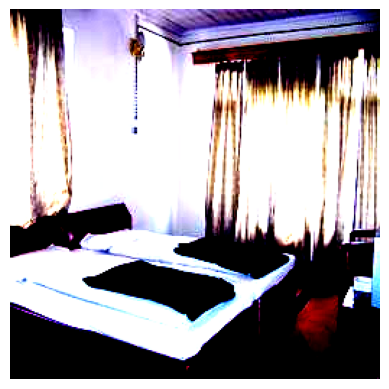

Available labels and their corresponding indices:
art_gallery: 0
banquet_hall: 1
hotel_room: 2
library_indoor: 3
supermarket: 4

You entered: 2

Real label:      hotel_room
Predicted label: hotel_room
User label:      hotel_room

its a draw


In [236]:
import random

# get a random image from the test dataset
image_nbre = random.randint(0, len(test_dataset))
rand_image, rand_label = test_dataset [image_nbre]

# Function to convert a tensor to a numpy array for printing
def imshow(image_tensor):
    image = image_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.show()

# Display the image without the label
imshow(rand_image)

# Get the real class name using the dataset class_to_idx mapping
real_label = dataset.classes[rand_label]

# Add a batch dimension to the image
rand_image = rand_image.unsqueeze(0)

# Get the predicted class name
if torch.cuda.is_available():
    rand_image, real_label = rand_image.cuda(), real_label.cuda()
outputs = model(rand_image)

# Apply softmax to get probabilities
probabilities = F.softmax(outputs, dim=1)

# Get the predicted class label
_, predicted_label = torch.max(probabilities, 1)

# Remove the batch dimension
predicted_label = predicted_label.item()

# transform it from a number to the predicted class
predicted_label=dataset.classes[predicted_label]

## for us to try to get the right class
# Access the class_to_idx attribute
class_to_idx = dataset.class_to_idx

# Print all available labels
print("Available labels and their corresponding indices:")
for label, idx in class_to_idx.items():
    print(f"{label}: {idx}")

print()

# Ask the user to gess the class
def get_user_input():
    while True:
        try:
            user_input = int(input("Please enter the class indice you think the image correspond to: "))
            print(f"You entered: {user_input}")
            break  # Exit the loop if input is valid
        except ValueError:
            print("That's not a valid number. Please try again.")
    return user_input

user_label=get_user_input()

# transform it from a number to the predicted class
user_label=dataset.classes[user_label]

# print
print()

print(f'Real label:      {real_label}')
print(f'Predicted label: {predicted_label}')
print(f'User label:      {user_label}')

print()

if predicted_label==real_label and user_label!=real_label:
    print("The machine won")

elif predicted_label!=real_label and user_label==real_label:
    print("You won")

else:
    print("its a draw")

### Export model weights

In [237]:
save_path = "./CNN256.pt"
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Model saved to: ./CNN256.pt
